In [1]:
#import cv2
import os

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image, ImageDraw
from tensorflow.keras import backend as K
import keras
#from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Add, Conv2D, SeparableConv2D
from tensorflow.keras.layers import BatchNormalization, AveragePooling2D
from tensorflow.keras.layers import LeakyReLU, MaxPooling2D, Flatten
from tensorflow.keras.models import Model

keras.saving.get_custom_objects().clear()

In [2]:
IMG_HEIGHT = 264
IMG_WIDTH = 640
X_FACTOR = 1
Y_FACTOR = 1
BATCH_SIZE = 128
EPOCHS = 30    # maybe mehr?
learning_rate = 0.0055    # 0.005
train_dataset_path = './images/train/'
test_dataset_path = './images/test/'

In [26]:
# Function to read images names and store them in a DataFrame
def grabPaths(filepath):
    labels = [str(filepath[i]).split("/")[-1] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='path').astype(str)
    
    # Concatenate filepaths and labels

    # Shuffle the DataFrame and reset index
    df = pd.DataFrame(filepath)
    
    return df

# Function to scale boxes coordinates (bacuase images are resized)
def resize_boxes(boxes):
    boxes = np.array(boxes).astype(np.float32)
    boxes = boxes * X_FACTOR
    return (np.rint(boxes)).astype(int)


# Function to draw bounding box given an image & coordinates
def plot_bbox(image, yt_box, yp_box=None, norm=False):
    # If image is normalized (/255.) reconstruct (inverse) the operation
    if norm:
        image = image * 255.
        image = image.astype("uint8")
    
    # Convert image to array if not converted
    try:
        pil_img = Image.fromarray(image)
    except:
        pil_img = Image.fromarray(image.astype('uint8'))
        
    draw_img = ImageDraw.Draw(pil_img)

    try:
        x1, y1, w = yt_box
        h = w
        x2, y2 = x1+w, y1+h
        draw_img.rectangle((x1, y1, x2, y2), outline='green')
    except:
        pass
    
    # If y_pred box is given, draw it
    if yp_box is not None:
        x1, y1, w = yp_box
        h = w
        x2, y2 = x1+w, y1+h
        draw_img.rectangle((x1, y1, x2+1, y2+1), outline='red')
    return pil_img


# Function to build convolutionl block
def convblock(previous_layer, n_filters, filter_windows=(3,3,3), padding='same', pool=None):
    # [DepthwiseConv -> BatchNorm -> LeakyReLU] x3 + Residual connection -> Pooling (optional)

    x = SeparableConv2D(n_filters[0], filter_windows[0], padding=padding)(previous_layer)
    x_short = x
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = SeparableConv2D(n_filters[1], filter_windows[1], padding=padding)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = SeparableConv2D(n_filters[2], filter_windows[2], padding=padding)(x)
    x = BatchNormalization()(x)
    x = Add()([x, x_short])
    x = LeakyReLU()(x)
    
    if pool == 'max':
        x = MaxPooling2D(pool_size=(2,2))(x)
    elif pool == 'avg':
        x = AveragePooling2D(pool_size=(2,2))(x)
    
    return x

# Function to show samples
def visualize_samples(datagen, row_col_len=4, figsize=None):
    figsize = figsize or np.array((row_col_len, row_col_len)) * 4
    fig, ax = plt.subplots(row_col_len*5, row_col_len, figsize=figsize)
    for i in range(row_col_len*5):
        for j in range(row_col_len):
            batch_index = np.random.randint(0, BATCH_SIZE/2)
            output_classes = np.array(datagen[batch_index][1]['class_out'])
            classes_true = np.where(output_classes == 1)[0]
            sample_index = classes_true[np.random.randint(0, classes_true.shape[0])]
            image = datagen[batch_index][0][sample_index]
            print(image.shape)
            box = datagen[batch_index][1]['box_out'][sample_index]
            plotted_box = plot_bbox(image, box, norm=True)
            ax[i,j].imshow(plotted_box)
            ax[i,j].set_axis_off()
            #ax[i,j].title.set_text(str(batch_index*BATCH_SIZE+sample_index))
    plt.show()
    


# Function to make a prediction during training
def visualize_prediction(model, data):    
    # Select a sample where an object exists
    output_classes = np.array(custom_test_gen[0][1]['class_out'])
    sample_index = np.where(output_classes == 1)[0]
    sample_index = sample_index[0] if sample_index[0] else 0 
    
    # Get image
    image = np.array([data[0][0][sample_index]])
    
    # Set y_true & y_pred for class & bounding box
    yt_box = np.array([custom_test_gen[0][1]['box_out'][sample_index]])
    yt_class = np.array([custom_test_gen[0][1]['class_out'][sample_index]])
    yp_class, yp_box = model.predict(image)

    # Plot bounding box on image & show it
    image_plotted = plot_bbox(image[0], yt_box[0], yp_box[0], norm=True) 
    plt.imshow(image_plotted)
    plt.axis('off')
    
    # Print y_true class & y_pred class
    print("Class: y_true=", yt_class, " | y_pred=", int(yp_class >= 0.5))
    plt.show()


# Function to reduce learning rate during training        
def lr_scheduler(epoch, lr):
    if epoch > 10:
        lr = lr * tf.math.exp(-0.1) #-0.15
        print(lr)
    return float(lr)


In [4]:
# Read CSV
train_dataset = pd.read_csv('./images/train/dataset2.csv')
train_dataset.columns = ['path', 'ball_exists', 'x', 'y', 'w', 'h']
test_dataset = pd.read_csv('./images/test/dataset2.csv')
test_dataset.columns = ['path', 'ball_exists', 'x', 'y', 'w', 'h']


# List directories of files
train_image_dir_hand = Path('./images/train')
train_filepaths_hand = list(train_image_dir_hand.glob(r'**/*.jpg'))
test_image_dir_hand = Path('./images/test')
test_filepaths_hand = list(train_image_dir_hand.glob(r'**/*.jpg'))

# Create dataframe of {paths, labels}
train_df_hand = grabPaths(train_filepaths_hand)
test_df_hand = grabPaths(test_filepaths_hand)

train_dataset['path'] = "./images/train/" + train_dataset['path']
test_dataset['path'] = "./images/test/" + test_dataset['path']


# Resize boxes, keep zeros if no object exists
train_dataset.iloc[:,2:] = resize_boxes(train_dataset.iloc[:,2:])
test_dataset.iloc[:,2:] = resize_boxes(test_dataset.iloc[:,2:])

[Text(0.5, 0, 'Object exists in image'), Text(0, 0.5, 'No. of Image')]

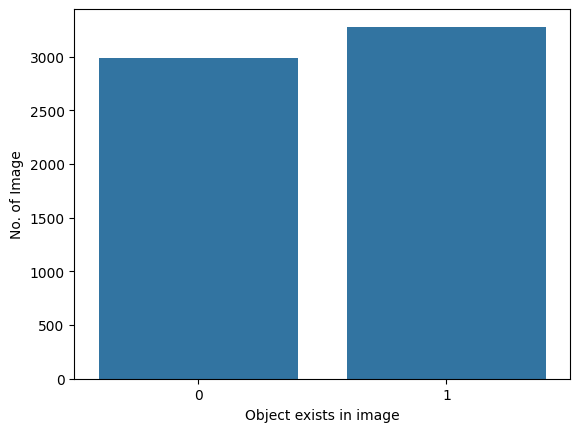

In [5]:
ax = sns.countplot(x='ball_exists', data=train_dataset)
ax.set(xlabel='Object exists in image', ylabel='No. of Image')

In [6]:
# balance dataset (undersampling)
# balls = dataset[dataset['ball_exists'] == 1]
# noballs = dataset[dataset['ball_exists'] == 0]
# balls = balls.sample(frac=0.75).reset_index(drop=True)

# # merge balanced classes & shuffle
# train_df = pd.concat((balls, noballs)).sample(frac=1.).reset_index(drop=True)

# train_df, test_df = train_test_split(train_df, test_size=0.2)

# print(f"No. Training Samples: {train_df.shape[0]}\nNo. Validation Samples: {test_df.shape[0]}")

In [7]:
# Create custom Generator for multiple output models
class MultiOutputGen(tf.keras.utils.Sequence):
    def __init__(self, input_gen, output_gen):
        self.inpgen = input_gen
        self.outgen = output_gen
#         assert len(input_gen) == len(output_gen)

    def __len__(self):
        return len(self.inpgen)

    def __getitem__(self, i):
        images = self.inpgen[i]
        start = i * images.shape[0]
        end = (i+1) * images.shape[0]
        classes_num = self.outgen.iloc[start:end,0].values
        x = self.outgen.iloc[start:end,1]
        y = self.outgen.iloc[start:end,2]
        w = self.outgen.iloc[start:end,3]
#         h = self.outgen.iloc[start:end,4]
        return images, {'class_out':classes_num, 'box_out':np.array([x, y, w]).T}

    def on_epoch_end(self):
        self.inpgen.on_epoch_end()
    
# Class to visualize predictions during training
class ConvergenceVisualization(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        global custom_test_gen
        visualize_prediction(self.model, custom_test_gen)

In [8]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    #brightness_range=(0.8, 1.2),
    rescale = 1./255.,
    #dtype=tf.uint8,
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255.,
    #dtype=tf.uint8,
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_dataset,
    x_col='path',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='rgb',
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_dataset,
    x_col='path',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='rgb',
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

# Create multi-output generator
custom_train_gen = MultiOutputGen(train_images, train_dataset.iloc[:,1:])
custom_test_gen = MultiOutputGen(test_images, test_dataset.iloc[:,1:])

Found 6269 validated image filenames.
Found 527 validated image filenames.


In [9]:
#visualize_samples(custom_train_gen, 2)

In [10]:
# BEST MODEL

inp = Input(shape=(IMG_HEIGHT,IMG_WIDTH,3), name='image')

X = SeparableConv2D(64, (7,7), strides=2, padding='valid')(inp)
X = MaxPooling2D(pool_size=(2,2), strides=2)(X)

X = SeparableConv2D(192, (3,3), strides=1, padding='same')(X)
X = MaxPooling2D(pool_size=(2,2), strides=2)(X)

X = convblock(X, [16, 16, 16], pool='max')
X = convblock(X, [32, 32, 32], pool='max')
X = convblock(X, [64, 64, 64], pool='max')
X = convblock(X, [128, 128, 128], pool='max')
X = convblock(X, [256, 256, 256])

X = Flatten()(X)
boxX = Dense(512)(X)
boxX = LeakyReLU()(boxX)

classX = Dense(128)(X)
classX = LeakyReLU()(classX)

box_out = Dense(3, name='box_out')(boxX)
class_out = Dense(1, name='class_out', activation='sigmoid')(classX)


model = Model(inp, [class_out, box_out])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)            │ (None, 264, 640, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d              │ (None, 129, 317, 64)      │             403 │ image[0][0]                │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 64, 158, 64)       │               0 │ separable_conv2d[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_1            │ (None, 64, 158, 192)      │          13,056 │ max_pooling2d[0][0]        │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 32, 79, 192)       │               0 │ separable_conv2d_1[0][0]   │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_2            │ (None, 32, 79, 16)        │           4,816 │ max_pooling2d_1[0][0]      │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 32, 79, 16)        │              64 │ separable_conv2d_2[0][0]   │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu (LeakyReLU)       │ (None, 32, 79, 16)        │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_3            │ (None, 32, 79, 16)        │             416 │ leaky_re_lu[0][0]          │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 32, 79, 16)        │              64 │ separable_conv2d_3[0][0]   │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU)     │ (None, 32, 79, 16)        │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_4            │ (None, 32, 79, 16)        │             416 │ leaky_re_lu_1[0][0]        │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 32, 79, 16)        │              64 │ separable_conv2d_4[0][0]   │
│ (BatchNormalization)          │                           │               

 Total params: 1,567,927 (5.98 MB)

 Trainable params: 1,564,951 (5.97 MB)

 Non-trainable params: 2,976 (11.62 KB)

In [11]:
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Function to calculate MSE Loss function
# for samples where object exists
@keras.saving.register_keras_serializable(package="custom_package", name="custom_mse")
def custom_mse(y_true, y_pred):
    print("mse y_pred: ", y_pred)
    mask = K.not_equal(K.sum(y_true, axis=1), 0.0)
    y_true_custom = y_true[mask]
    y_pred_custom = y_pred[mask]
    print("mse y_pred_custom: ", y_pred_custom)
    mse = tf.keras.losses.MeanSquaredError()
    result = mse(y_true_custom, y_pred_custom) # * 0.3
    print("mse result: ", result)
    return result

model.compile(
    loss={
        "box_out":custom_mse,
        'class_out':'binary_crossentropy'
    },
    metrics={
        'class_out':'accuracy'
    },
    optimizer=adam
)

C:\Users\Salkin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
mse y_pred:  Tensor("functional_1/box_out_1/BiasAdd:0", shape=(None, 3), dtype=float32)
mse y_pred_custom:  Tensor("compile_loss/custom_mse/boolean_mask_1/GatherV2:0", shape=(None, 3), dtype=float32)
mse result:  Tensor("compile_loss/custom_mse/mean_squared_error/div_no_nan:0", shape=(), dtype=float32)
mse y_pred:  Tensor("functional_1/box_out_1/BiasAdd:0", shape=(None, 3), dtype=float32)
mse y_pred_custom:  Tensor("compile_loss/custom_mse/boolean_mask_1/GatherV2:0", shape=(None, 3), dtype=float32)
mse result:  Tensor("compile_loss/custom_mse/mean_squared_error/div_no_nan:0", shape=(), dtype=float32)
mse y_pred:  Tensor("functional_1/box_out_1/BiasAdd:0", shape=(None, 3), dtype=float32)ss: 7664.6694 - class_out_accuracy: 0.4663 - class_out_loss: 5.4328 - loss: 7681.7188 
mse y_pred_custom:  Tensor("compile_loss/custom_mse/boolean_mask_1/GatherV2:0", shape=(None, 3), dtype=float32)
mse result:  Tensor("compile_loss/custom_mse/mean_squared_error/div_no_nan:0", shape=(), dtype=

C:\Users\Salkin\AppData\Local\Temp\ipykernel_35612\3657912104.py:118: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Class: y_true=", yt_class, " | y_pred=", int(yp_class >= 0.5))


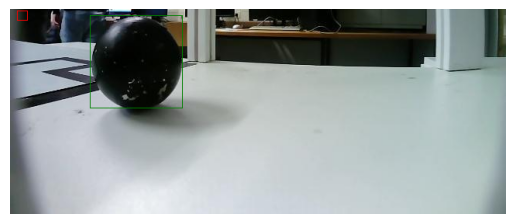

49/49 ━━━━━━━━━━━━━━━━━━━━ 48s 864ms/step - box_out_loss: 7629.0874 - class_out_accuracy: 0.4659 - class_out_loss: 5.3856 - loss: 7645.9136 - val_box_out_loss: 17471.6523 - val_class_out_accuracy: 0.2694 - val_class_out_loss: 0.6998 - val_loss: 11142.1650 - learning_rate: 0.0055
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/steptep - box_out_loss: 2961.7795 - class_out_accuracy: 0.4176 - class_out_loss: 1.5777 - loss: 2963.8257 
Class: y_true= [1]  | y_pred= 0


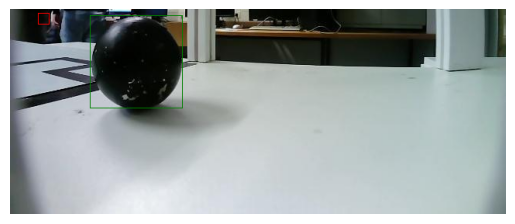

49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 836ms/step - box_out_loss: 2973.2834 - class_out_accuracy: 0.4193 - class_out_loss: 1.5830 - loss: 2975.3594 - val_box_out_loss: 15614.7715 - val_class_out_accuracy: 0.7306 - val_class_out_loss: 0.6755 - val_loss: 9933.6201 - learning_rate: 0.0055
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 3578.4407 - class_out_accuracy: 0.4526 - class_out_loss: 1.4987 - loss: 3582.3376     
Class: y_true= [1]  | y_pred= 0


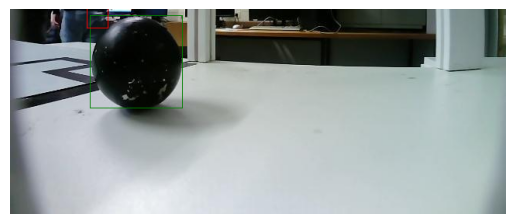

49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 837ms/step - box_out_loss: 3563.6487 - class_out_accuracy: 0.4536 - class_out_loss: 1.4969 - loss: 3567.5227 - val_box_out_loss: 11686.5283 - val_class_out_accuracy: 0.7306 - val_class_out_loss: 1.5602 - val_loss: 7398.1465 - learning_rate: 0.0055
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/steptep - box_out_loss: 3271.5383 - class_out_accuracy: 0.4603 - class_out_loss: 3.1290 - loss: 3276.3325      
Class: y_true= [1]  | y_pred= 1


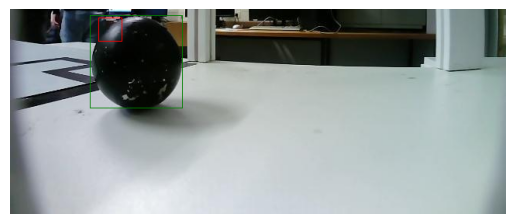

49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 837ms/step - box_out_loss: 3262.4431 - class_out_accuracy: 0.4613 - class_out_loss: 3.1079 - loss: 3267.2097 - val_box_out_loss: 10697.9062 - val_class_out_accuracy: 0.2694 - val_class_out_loss: 1.0106 - val_loss: 6719.6553 - learning_rate: 0.0055
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/steptep - box_out_loss: 2168.6050 - class_out_accuracy: 0.5268 - class_out_loss: 1.2317 - loss: 2170.0969   
Class: y_true= [1]  | y_pred= 1


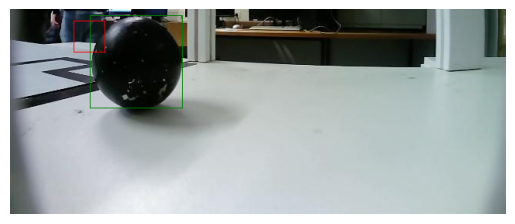

49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 834ms/step - box_out_loss: 2168.9355 - class_out_accuracy: 0.5275 - class_out_loss: 1.2238 - loss: 2170.4351 - val_box_out_loss: 10150.5371 - val_class_out_accuracy: 0.7552 - val_class_out_loss: 0.6703 - val_loss: 6165.9307 - learning_rate: 0.0055
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/steptep - box_out_loss: 1746.7880 - class_out_accuracy: 0.5892 - class_out_loss: 0.7330 - loss: 1747.9109 
Class: y_true= [1]  | y_pred= 1


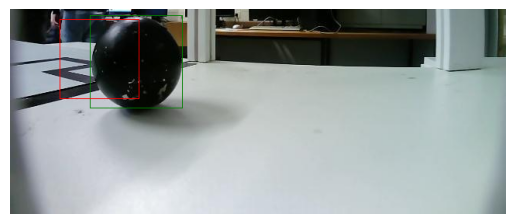

49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 839ms/step - box_out_loss: 1749.0446 - class_out_accuracy: 0.5876 - class_out_loss: 0.7354 - loss: 1750.1798 - val_box_out_loss: 7780.0635 - val_class_out_accuracy: 0.5882 - val_class_out_loss: 0.6909 - val_loss: 4019.3567 - learning_rate: 0.0055
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/steptep - box_out_loss: 2344.8376 - class_out_accuracy: 0.4860 - class_out_loss: 0.7829 - loss: 2347.9207 
Class: y_true= [1]  | y_pred= 1


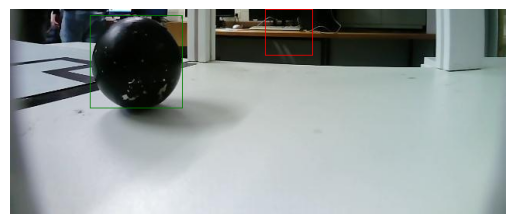

49/49 ━━━━━━━━━━━━━━━━━━━━ 43s 869ms/step - box_out_loss: 2344.0017 - class_out_accuracy: 0.4853 - class_out_loss: 0.7837 - loss: 2347.0618 - val_box_out_loss: 8661.0566 - val_class_out_accuracy: 0.2543 - val_class_out_loss: 1.1826 - val_loss: 5880.8984 - learning_rate: 0.0055
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/steptep - box_out_loss: 1625.2262 - class_out_accuracy: 0.5400 - class_out_loss: 0.7304 - loss: 1626.1154 
Class: y_true= [1]  | y_pred= 1


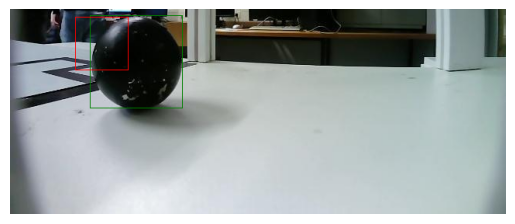

49/49 ━━━━━━━━━━━━━━━━━━━━ 42s 854ms/step - box_out_loss: 1626.1652 - class_out_accuracy: 0.5402 - class_out_loss: 0.7297 - loss: 1627.0665 - val_box_out_loss: 5132.6934 - val_class_out_accuracy: 0.4137 - val_class_out_loss: 0.7349 - val_loss: 2300.1536 - learning_rate: 0.0055
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 1287.6600 - class_out_accuracy: 0.6279 - class_out_loss: 0.6414 - loss: 1288.6764 
Class: y_true= [1]  | y_pred= 0


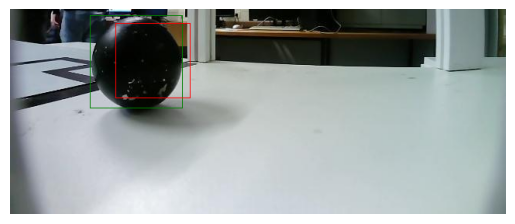

49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 837ms/step - box_out_loss: 1284.2047 - class_out_accuracy: 0.6279 - class_out_loss: 0.6415 - loss: 1285.2244 - val_box_out_loss: 3925.9285 - val_class_out_accuracy: 0.7343 - val_class_out_loss: 0.7816 - val_loss: 1508.3403 - learning_rate: 0.0055
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/steptep - box_out_loss: 1029.4285 - class_out_accuracy: 0.5258 - class_out_loss: 0.7208 - loss: 1031.6714 
Class: y_true= [1]  | y_pred= 1


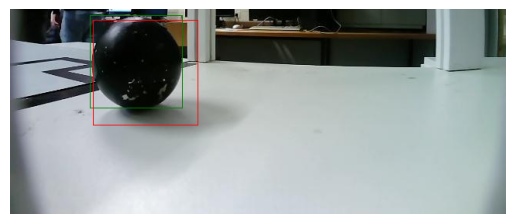

49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 837ms/step - box_out_loss: 1028.6245 - class_out_accuracy: 0.5269 - class_out_loss: 0.7199 - loss: 1030.8456 - val_box_out_loss: 9714.8154 - val_class_out_accuracy: 0.3776 - val_class_out_loss: 0.7946 - val_loss: 8315.3955 - learning_rate: 0.0055
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/steptep - box_out_loss: 847.4606 - class_out_accuracy: 0.6573 - class_out_loss: 0.6284 - loss: 848.4556   
Class: y_true= [1]  | y_pred= 1


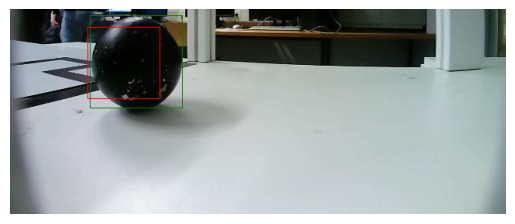

49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 830ms/step - box_out_loss: 845.5668 - class_out_accuracy: 0.6571 - class_out_loss: 0.6285 - loss: 846.5616 - val_box_out_loss: 4420.6987 - val_class_out_accuracy: 0.6281 - val_class_out_loss: 0.7219 - val_loss: 1404.4363 - learning_rate: 0.0055
tf.Tensor(0.004976606, shape=(), dtype=float32)
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 641.9045 - class_out_accuracy: 0.7393 - class_out_loss: 0.5482 - loss: 642.6776   
Class: y_true= [1]  | y_pred= 1


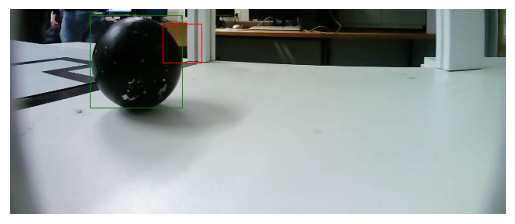

49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 829ms/step - box_out_loss: 640.0710 - class_out_accuracy: 0.7379 - class_out_loss: 0.5497 - loss: 640.8464 - val_box_out_loss: 5200.9990 - val_class_out_accuracy: 0.7211 - val_class_out_loss: 0.8302 - val_loss: 2331.1060 - learning_rate: 0.0050
tf.Tensor(0.004503019, shape=(), dtype=float32)
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/steptep - box_out_loss: 565.3588 - class_out_accuracy: 0.7054 - class_out_loss: 0.8076 - loss: 566.2166 
Class: y_true= [1]  | y_pred= 1


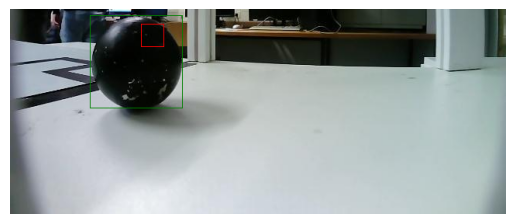

49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 831ms/step - box_out_loss: 565.6461 - class_out_accuracy: 0.7052 - class_out_loss: 0.8054 - loss: 566.5063 - val_box_out_loss: 3911.5750 - val_class_out_accuracy: 0.4611 - val_class_out_loss: 0.7542 - val_loss: 1354.6150 - learning_rate: 0.0045
tf.Tensor(0.0040745004, shape=(), dtype=float32)
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/steptep - box_out_loss: 484.0264 - class_out_accuracy: 0.7479 - class_out_loss: 0.5377 - loss: 485.1334 
Class: y_true= [1]  | y_pred= 1


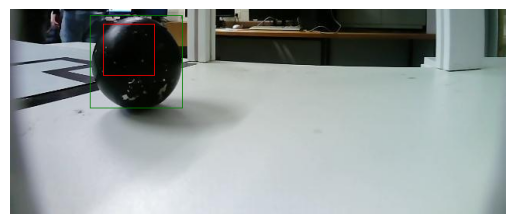

49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 833ms/step - box_out_loss: 484.3602 - class_out_accuracy: 0.7474 - class_out_loss: 0.5379 - loss: 485.4607 - val_box_out_loss: 4440.3262 - val_class_out_accuracy: 0.4497 - val_class_out_loss: 0.7859 - val_loss: 1394.1945 - learning_rate: 0.0041
tf.Tensor(0.0036867606, shape=(), dtype=float32)
Epoch 15/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/steptep - box_out_loss: 382.2549 - class_out_accuracy: 0.7752 - class_out_loss: 0.4714 - loss: 382.9681 
Class: y_true= [1]  | y_pred= 1


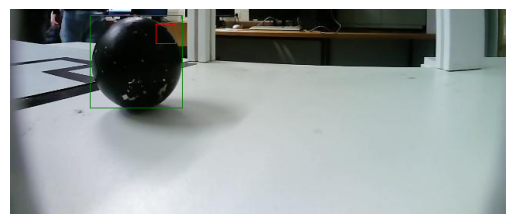

49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 834ms/step - box_out_loss: 382.2072 - class_out_accuracy: 0.7755 - class_out_loss: 0.4710 - loss: 382.9188 - val_box_out_loss: 4756.2646 - val_class_out_accuracy: 0.5427 - val_class_out_loss: 0.8476 - val_loss: 1589.8890 - learning_rate: 0.0037
tf.Tensor(0.003335919, shape=(), dtype=float32)
Epoch 16/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/steptep - box_out_loss: 155.0264 - class_out_accuracy: 0.8651 - class_out_loss: 0.3438 - loss: 155.4338 
Class: y_true= [1]  | y_pred= 1


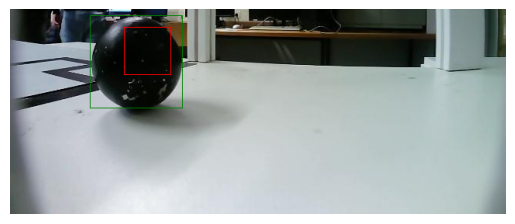

49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 837ms/step - box_out_loss: 155.9463 - class_out_accuracy: 0.8651 - class_out_loss: 0.3436 - loss: 156.3542 - val_box_out_loss: 4283.9170 - val_class_out_accuracy: 0.6110 - val_class_out_loss: 0.8419 - val_loss: 1331.0820 - learning_rate: 0.0033
tf.Tensor(0.0030184644, shape=(), dtype=float32)
Epoch 17/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/steptep - box_out_loss: 171.9652 - class_out_accuracy: 0.9191 - class_out_loss: 0.2427 - loss: 172.2759 
Class: y_true= [1]  | y_pred= 1


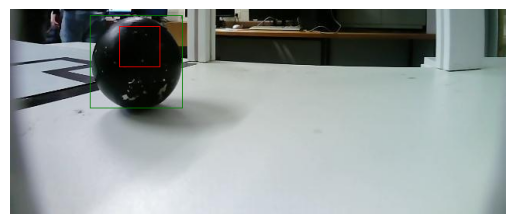

49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 831ms/step - box_out_loss: 171.8452 - class_out_accuracy: 0.9192 - class_out_loss: 0.2425 - loss: 172.1558 - val_box_out_loss: 4710.4717 - val_class_out_accuracy: 0.6622 - val_class_out_loss: 1.0145 - val_loss: 1417.8771 - learning_rate: 0.0030
tf.Tensor(0.0027312196, shape=(), dtype=float32)
Epoch 18/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/steptep - box_out_loss: 101.6359 - class_out_accuracy: 0.9444 - class_out_loss: 0.1765 - loss: 101.8406 
Class: y_true= [1]  | y_pred= 1


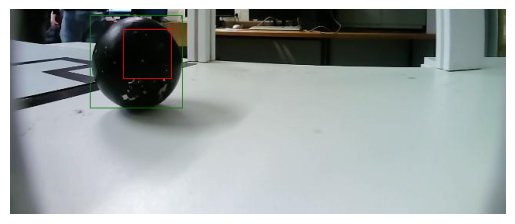

49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 833ms/step - box_out_loss: 102.2308 - class_out_accuracy: 0.9442 - class_out_loss: 0.1766 - loss: 102.4362 - val_box_out_loss: 4457.5986 - val_class_out_accuracy: 0.3795 - val_class_out_loss: 1.1886 - val_loss: 1286.4999 - learning_rate: 0.0027
tf.Tensor(0.0024713099, shape=(), dtype=float32)
Epoch 19/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 132.7118 - class_out_accuracy: 0.9005 - class_out_loss: 0.2466 - loss: 133.0895 
Class: y_true= [1]  | y_pred= 0


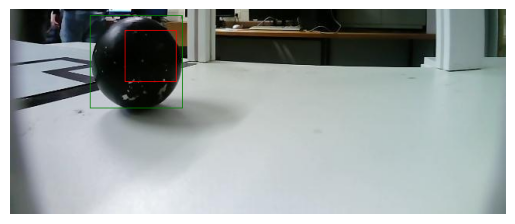

49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 833ms/step - box_out_loss: 132.2910 - class_out_accuracy: 0.9007 - class_out_loss: 0.2464 - loss: 132.6669 - val_box_out_loss: 4213.2407 - val_class_out_accuracy: 0.6926 - val_class_out_loss: 0.8039 - val_loss: 1224.2231 - learning_rate: 0.0025
tf.Tensor(0.0022361337, shape=(), dtype=float32)
Epoch 20/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 90.4628 - class_out_accuracy: 0.9625 - class_out_loss: 0.1338 - loss: 90.6040   
Class: y_true= [1]  | y_pred= 0


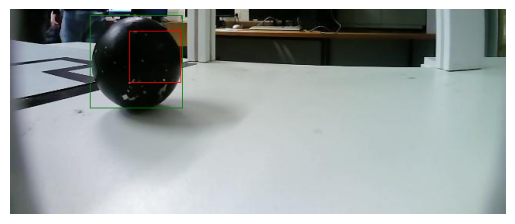

49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 831ms/step - box_out_loss: 90.6460 - class_out_accuracy: 0.9619 - class_out_loss: 0.1349 - loss: 90.7891 - val_box_out_loss: 4114.7529 - val_class_out_accuracy: 0.7552 - val_class_out_loss: 1.4600 - val_loss: 1234.1172 - learning_rate: 0.0022
tf.Tensor(0.0020233374, shape=(), dtype=float32)
Epoch 21/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 85.7838 - class_out_accuracy: 0.8710 - class_out_loss: 0.2838 - loss: 86.0684   
Class: y_true= [1]  | y_pred= 0


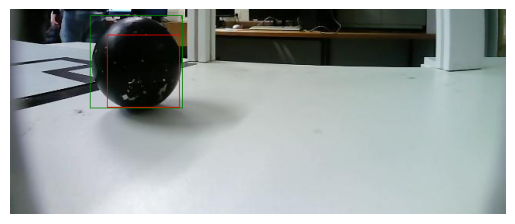

49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 831ms/step - box_out_loss: 85.7781 - class_out_accuracy: 0.8715 - class_out_loss: 0.2829 - loss: 86.0626 - val_box_out_loss: 4605.0127 - val_class_out_accuracy: 0.7230 - val_class_out_loss: 0.8919 - val_loss: 1400.0656 - learning_rate: 0.0020
tf.Tensor(0.0018307915, shape=(), dtype=float32)
Epoch 22/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/steptep - box_out_loss: 89.0954 - class_out_accuracy: 0.9565 - class_out_loss: 0.1332 - loss: 89.2402   
Class: y_true= [1]  | y_pred= 1


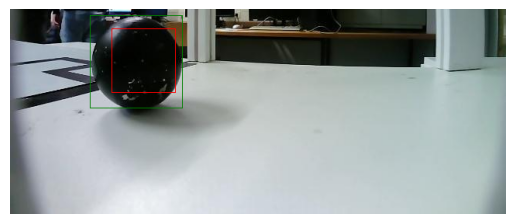

49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 833ms/step - box_out_loss: 89.1980 - class_out_accuracy: 0.9565 - class_out_loss: 0.1332 - loss: 89.3434 - val_box_out_loss: 4419.0688 - val_class_out_accuracy: 0.5313 - val_class_out_loss: 0.8816 - val_loss: 1465.2980 - learning_rate: 0.0018
tf.Tensor(0.0016565686, shape=(), dtype=float32)
Epoch 23/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 102.6904 - class_out_accuracy: 0.9632 - class_out_loss: 0.1064 - loss: 102.8847 
Class: y_true= [1]  | y_pred= 1


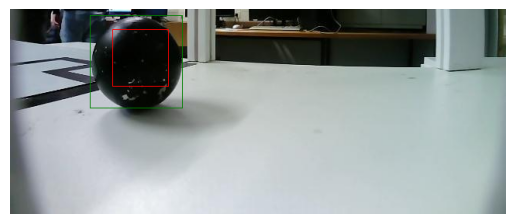

49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 835ms/step - box_out_loss: 102.5249 - class_out_accuracy: 0.9630 - class_out_loss: 0.1069 - loss: 102.7189 - val_box_out_loss: 4571.0366 - val_class_out_accuracy: 0.5009 - val_class_out_loss: 0.8903 - val_loss: 1280.1616 - learning_rate: 0.0017
tf.Tensor(0.0014989253, shape=(), dtype=float32)
Epoch 24/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/steptep - box_out_loss: 62.4975 - class_out_accuracy: 0.9372 - class_out_loss: 0.1592 - loss: 62.6863   
Class: y_true= [1]  | y_pred= 0


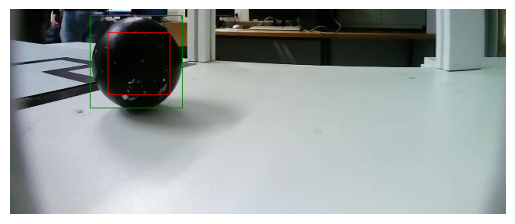

49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 828ms/step - box_out_loss: 62.6832 - class_out_accuracy: 0.9372 - class_out_loss: 0.1591 - loss: 62.8720 - val_box_out_loss: 4585.1782 - val_class_out_accuracy: 0.3833 - val_class_out_loss: 1.2167 - val_loss: 1329.1639 - learning_rate: 0.0015
tf.Tensor(0.0013562837, shape=(), dtype=float32)
Epoch 25/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/steptep - box_out_loss: 77.5836 - class_out_accuracy: 0.9650 - class_out_loss: 0.0984 - loss: 77.7092   
Class: y_true= [1]  | y_pred= 0


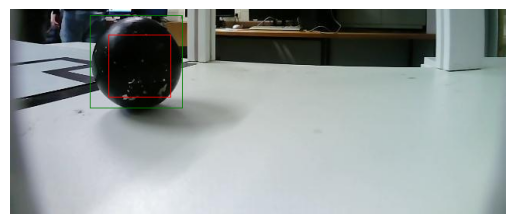

49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 828ms/step - box_out_loss: 77.4331 - class_out_accuracy: 0.9650 - class_out_loss: 0.0985 - loss: 77.5591 - val_box_out_loss: 4637.4175 - val_class_out_accuracy: 0.7059 - val_class_out_loss: 0.9678 - val_loss: 1388.6826 - learning_rate: 0.0014
tf.Tensor(0.0012272162, shape=(), dtype=float32)
Epoch 26/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 57.0943 - class_out_accuracy: 0.9596 - class_out_loss: 0.1099 - loss: 57.2648   
Class: y_true= [1]  | y_pred= 0


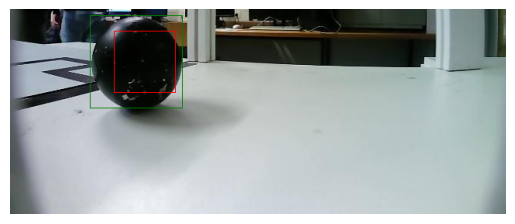

49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 830ms/step - box_out_loss: 57.0915 - class_out_accuracy: 0.9598 - class_out_loss: 0.1097 - loss: 57.2611 - val_box_out_loss: 4801.0547 - val_class_out_accuracy: 0.5882 - val_class_out_loss: 0.7443 - val_loss: 1304.9640 - learning_rate: 0.0012
tf.Tensor(0.0011104312, shape=(), dtype=float32)
Epoch 27/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/steptep - box_out_loss: 67.5459 - class_out_accuracy: 0.9679 - class_out_loss: 0.1002 - loss: 67.6555   
Class: y_true= [1]  | y_pred= 0


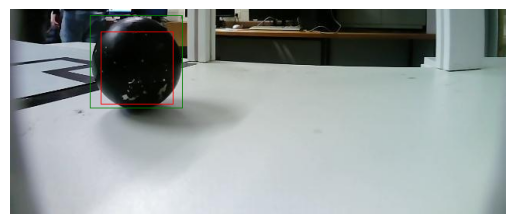

49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 828ms/step - box_out_loss: 67.1486 - class_out_accuracy: 0.9680 - class_out_loss: 0.1000 - loss: 67.2584 - val_box_out_loss: 4433.5815 - val_class_out_accuracy: 0.6357 - val_class_out_loss: 0.7864 - val_loss: 1380.3228 - learning_rate: 0.0011
tf.Tensor(0.0010047597, shape=(), dtype=float32)
Epoch 28/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 44.7714 - class_out_accuracy: 0.9841 - class_out_loss: 0.0657 - loss: 44.8510   
Class: y_true= [1]  | y_pred= 0


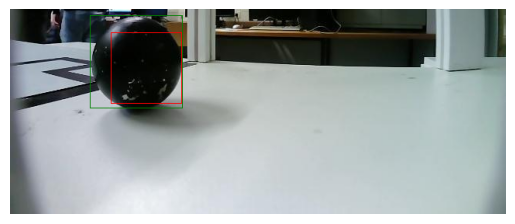

49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 830ms/step - box_out_loss: 44.8561 - class_out_accuracy: 0.9839 - class_out_loss: 0.0659 - loss: 44.9362 - val_box_out_loss: 4811.9658 - val_class_out_accuracy: 0.6679 - val_class_out_loss: 0.7295 - val_loss: 1319.4691 - learning_rate: 0.0010
tf.Tensor(0.0009091442, shape=(), dtype=float32)
Epoch 29/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/steptep - box_out_loss: 56.9112 - class_out_accuracy: 0.9790 - class_out_loss: 0.0757 - loss: 56.9979 
Class: y_true= [1]  | y_pred= 0


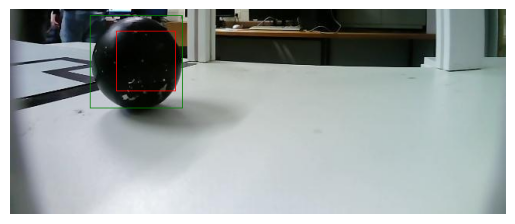

49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 830ms/step - box_out_loss: 56.7490 - class_out_accuracy: 0.9790 - class_out_loss: 0.0756 - loss: 56.8358 - val_box_out_loss: 4753.0068 - val_class_out_accuracy: 0.6945 - val_class_out_loss: 0.7341 - val_loss: 1300.3409 - learning_rate: 9.0914e-04
tf.Tensor(0.0008226277, shape=(), dtype=float32)
Epoch 30/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/steptep - box_out_loss: 52.0044 - class_out_accuracy: 0.9807 - class_out_loss: 0.0691 - loss: 52.1300 
Class: y_true= [1]  | y_pred= 0


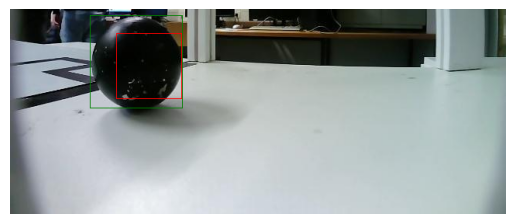

49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 831ms/step - box_out_loss: 51.8302 - class_out_accuracy: 0.9807 - class_out_loss: 0.0692 - loss: 51.9552 - val_box_out_loss: 4914.4346 - val_class_out_accuracy: 0.6319 - val_class_out_loss: 0.7664 - val_loss: 1347.3513 - learning_rate: 8.2263e-04


In [12]:
history = model.fit(
    custom_train_gen,
    epochs=EPOCHS,
    validation_data=custom_test_gen,
    callbacks=[
        tf.keras.callbacks.LearningRateScheduler(lr_scheduler),
        ConvergenceVisualization()
    ]
)

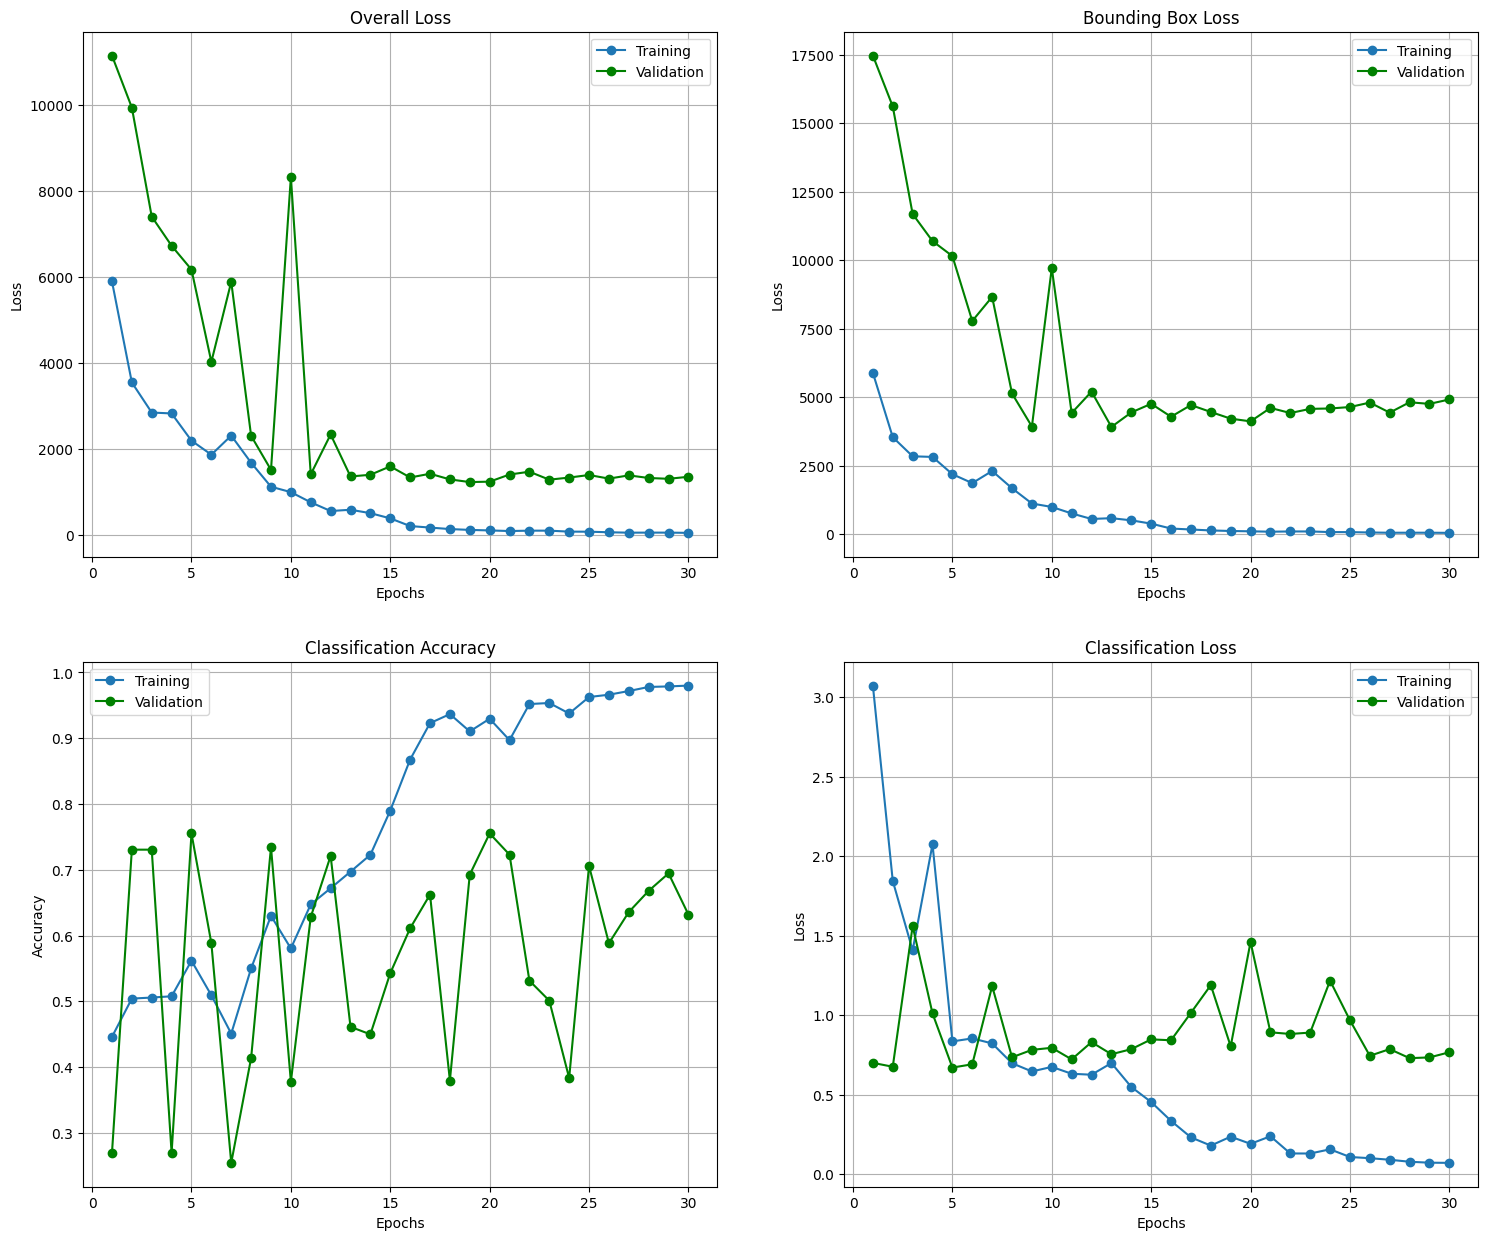

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [13]:
# Accuracy & Loss Visualization

#  Overall Loss
train_overall_loss = history.history['loss']
val_overall_loss = history.history['val_loss']

# Classification Accuracy
train_classification_acc = history.history['class_out_accuracy']
val_classification_acc = history.history['val_class_out_accuracy']

# Classification Loss
train_classification_loss = history.history['class_out_loss']
val_classification_loss = history.history['val_class_out_loss']

# Bounding Box Loss
train_bbox_loss = history.history['box_out_loss']
val_bbox_loss = history.history['val_box_out_loss']

epochs = range(1, len(history.history['loss'])+1)

f, ax = plt.subplots(nrows=2,ncols=2,figsize=(18,15))
    
ax[0,0].plot(epochs, train_overall_loss,  marker='o', label='Training')
ax[0,0].plot(epochs, val_overall_loss, marker='o', color = 'green', label='Validation')
ax[0,0].set_title('Overall Loss')
ax[0,0].set_xlabel('Epochs')
ax[0,0].set_ylabel('Loss')
ax[0,0].legend(loc='best')
ax[0,0].grid(True)

ax[0,1].plot(epochs, train_bbox_loss, marker='o', label='Training')
ax[0,1].plot(epochs, val_bbox_loss, marker='o', color = 'green', label='Validation')
ax[0,1].set_title('Bounding Box Loss')
ax[0,1].set_xlabel('Epochs')
ax[0,1].set_ylabel('Loss')
ax[0,1].legend(loc='best')
ax[0,1].grid(True)



ax[1,0].plot(epochs, train_classification_acc,  marker='o', label='Training')
ax[1,0].plot(epochs, val_classification_acc, marker='o', color = 'green', label='Validation')
ax[1,0].set_title('Classification Accuracy')
ax[1,0].set_xlabel('Epochs')
ax[1,0].set_ylabel('Accuracy')
ax[1,0].legend(loc='best')
ax[1,0].grid(True)

ax[1,1].plot(epochs, train_classification_loss, marker='o', label='Training')
ax[1,1].plot(epochs, val_classification_loss, marker='o', color = 'green', label='Validation')
ax[1,1].set_title('Classification Loss')
ax[1,1].set_xlabel('Epochs')
ax[1,1].set_ylabel('Loss')
ax[1,1].legend(loc='best')
ax[1,1].grid(True)

plt.show()
f.savefig('LossAndAccuracy.eps', format='eps')
plt.close()

In [14]:
#model.save("test1 ball detection.h5")
model.save("ball_detection_V2.keras")


In [15]:
#converter = tf.lite.TFLiteConverter.from_keras_model(model)
#tflite_model = converter.convert()
#open("ball_detection_V2.tflite", "wb").write(tflite_model)

In [16]:
@keras.saving.register_keras_serializable(package="custom_package", name="custom_mse")
def custom_mse(y_true, y_pred):
    print("mse y_pred: ", y_pred)
    mask = K.not_equal(K.sum(y_true, axis=1), 0.0)
    y_true_custom = y_true[mask]
    y_pred_custom = y_pred[mask]
    print("mse y_pred_custom: ", y_pred_custom)
    mse = tf.keras.losses.MeanSquaredError()
    result = mse(y_true_custom, y_pred_custom) # * 0.3
    print("mse result: ", result)
    return result
new_model = tf.keras.models.load_model("ball_detection_V2.keras")
new_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)            │ (None, 264, 640, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d              │ (None, 129, 317, 64)      │             403 │ image[0][0]                │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 64, 158, 64)       │               0 │ separable_conv2d[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_1            │ (None, 64, 158, 192)      │          13,056 │ max_pooling2d[0][0]        │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 32, 79, 192)       │               0 │ separable_conv2d_1[0][0]   │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_2            │ (None, 32, 79, 16)        │           4,816 │ max_pooling2d_1[0][0]      │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 32, 79, 16)        │              64 │ separable_conv2d_2[0][0]   │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu (LeakyReLU)       │ (None, 32, 79, 16)        │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_3            │ (None, 32, 79, 16)        │             416 │ leaky_re_lu[0][0]          │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 32, 79, 16)        │              64 │ separable_conv2d_3[0][0]   │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU)     │ (None, 32, 79, 16)        │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_4            │ (None, 32, 79, 16)        │             416 │ leaky_re_lu_1[0][0]        │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 32, 79, 16)        │              64 │ separable_conv2d_4[0][0]   │
│ (BatchNormalization)          │                           │               

 Total params: 4,697,831 (17.92 MB)

 Trainable params: 1,564,951 (5.97 MB)

 Non-trainable params: 2,976 (11.62 KB)

 Optimizer params: 3,129,904 (11.94 MB)

In [17]:
#def representative_dataset():
#    c = 0
#    test_images.reset()
#    for ind in range (len(test_images.filenames)):
#        #data_list = []
#        try:
#            data = test_images[ind]
#        #print(data)
#        #data_list.append(data[0])
#
#            for i in range(BATCH_SIZE):
#                c+=1
#        # now, data_array is the numeric data of whole images
#                data_array = np.asarray(data[i])*255
#                data_array = np.expand_dims(data_array, axis=0)
#        #print(data_array.shape)
#        #data_array=np.squeeze(data_array,axis=0)
#        #print(data_array.shape)
#        
#                yield [np.array(data_array, dtype=np.float32, ndmin=2)]
#        except:
#            print(c)
#            break

#converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
#converter.optimizations = [tf.lite.Optimize.DEFAULT]
#converter.experimental_new_quantizer = True
#converter.representative_dataset = representative_dataset
#converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
#converter.inference_input_type = tf.uint8
#converter.inference_output_type = tf.uint8
#tflite_model = converter.convert()
#open("ball_detection_uint8.tflite", "wb").write(tflite_model)

In [18]:
#interpreter = tf.lite.Interpreter(model_path='ball_detection_uint8.tflite')
#interpreter.allocate_tensors()
#input_details = interpreter.get_input_details()
#output_details = interpreter.get_output_details()
#input_data = image = np.expand_dims(np.asarray(Image.open("./images/valid/frame598.jpg")), axis=0)
#interpreter.set_tensor(input_details[0]['index'], input_data)
#interpreter.invoke()
#output_data = interpreter.get_tensor(output_details[0]['index'])
#print(output_data)
#output_data = interpreter.get_tensor(output_details[1]['index'])
#print(output_data)

In [19]:
valid_dataset = pd.read_csv('./images/valid/dataset.csv')
#print(valid_dataset)
def visualize_evaluation(model, name):    
    # Get image
    im = Image.open("./images/valid/"+name)
    image = np.expand_dims(np.asarray(im)/255, axis=0)
    #image = np.expand_dims(np.asarray(im)/255, axis=0)
    print(image.shape)
    #print(image)
    
    # Set y_true & y_pred for class & bounding box
    print(valid_dataset.loc[valid_dataset['path']==name]['x'], valid_dataset.loc[valid_dataset['path']==name]['y'], valid_dataset.loc[valid_dataset['path']==name]['w'])
    yt_box = np.array([valid_dataset.loc[valid_dataset['path']==name]['x'], valid_dataset.loc[valid_dataset['path']==name]['y'], valid_dataset.loc[valid_dataset['path']==name]['w']])
    yt_class = np.array(valid_dataset.loc[valid_dataset['path']==name]['ball_exists'])
    
    yp_class, yp_box = model.predict(image)
    print(yp_class, yp_box)

    camera_fov = 120
    angle = (yp_box[0][0]+yp_box[0][2]/2)/640 *camera_fov - camera_fov/2
    print("Ball Angle", angle)

    # Plot bounding box on image & show it
    image_plotted = plot_bbox(image[0], yt_box, yp_box[0], norm=True) #True?
    plt.imshow(image_plotted)
    plt.axis('off')
    
    # Print y_true class & y_pred class
    print("Class: y_true=", yt_class, " | y_pred=", int(yp_class[0][0] >= 0.5))
    plt.show()

(1, 264, 640, 3)
1302    0
Name: x, dtype: int64 1302    0
Name: y, dtype: int64 1302    0
Name: w, dtype: int64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[0.04027247]] [[275.7725    13.011412  65.30267 ]]
Ball Angle -2.1705322
Class: y_true= [0]  | y_pred= 0


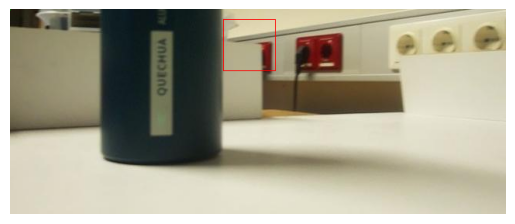

In [48]:
visualize_evaluation(new_model, "frame795.jpg")

In [21]:
def visu_tets(sample_index):
    data = custom_test_gen
    image = np.array([data[0][0][sample_index]])
    yt_box = np.array([custom_test_gen[0][1]['box_out'][sample_index]])
    yt_class = np.array([custom_test_gen[0][1]['class_out'][sample_index]])
    yp_class, yp_box = model.predict(image)
    print(image.shape)
    print(image)
    print(image[0].shape)
    image_plotted = plot_bbox(image[0], yt_box[0], yp_box[0], norm=True) 
    plt.imshow(image_plotted)
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
(1, 264, 640, 3)
[[[[0.29803923 0.32156864 0.3137255 ]
   [0.29803923 0.32156864 0.3137255 ]
   [0.2901961  0.3137255  0.30588236]
   ...
   [0.24705884 0.29803923 0.19607845]
   [0.25490198 0.3019608  0.21568629]
   [0.25882354 0.30588236 0.227451  ]]

  [[0.29803923 0.32156864 0.3137255 ]
   [0.29411766 0.31764707 0.30980393]
   [0.2901961  0.3137255  0.30588236]
   ...
   [0.24705884 0.29803923 0.19607845]
   [0.25490198 0.3019608  0.21568629]
   [0.25882354 0.30588236 0.227451  ]]

  [[0.29803923 0.32156864 0.3137255 ]
   [0.29411766 0.31764707 0.30980393]
   [0.2901961  0.3137255  0.30588236]
   ...
   [0.2509804  0.3019608  0.20000002]
   [0.25490198 0.3019608  0.21568629]
   [0.2627451  0.30980393 0.23137257]]

  ...

  [[0.3137255  0.32156864 0.31764707]
   [0.30588236 0.32156864 0.31764707]
   [0.30588236 0.32156864 0.31764707]
   ...
   [0.42352945 0.48627454 0.48627454]
   [0.41960788 0.48235297 0.48235297]
   [0.4156863  0.4784314  0.47

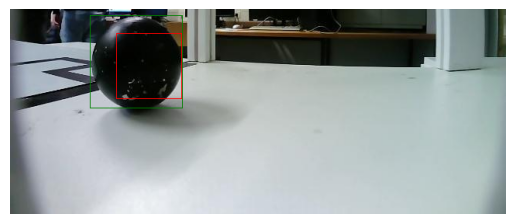

In [22]:
visu_tets(0)